# SVC with in-situ data
<br/>
We will use here the same method as in "svc_lab" notebook. The model will be train to predict the clusters defined in the "hplc_cluster" notebook. <br/> The dataset is  hplc_mfclusterised.

In [1]:
import pandas as pd 

data = pd.read_csv("C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Data\Compiled\ml_dataset.csv")

print(
    f"The original data has "
    f"{len(data)} samples.")

The original data has 86 samples.


Select the descriptors (f440/f470 and f532/f47) and the target variable (the cluster).

In [2]:
descriptors = data[["f440_f470", "f532_f470"]]
target = data["cluster"]

data.head()

,bouss,depth,fluo_440,fluo_470,fluo_532,cp,f440_f470,f532_f470,cluster,bb700
0,225,80,20.648569,26.128788,2.658249,0.077227,0.790261,0.746067,0,657.553626
1,225,70,21.123352,28.637476,2.979441,0.085750,0.737612,0.762960,0,642.401948
2,225,60,29.506494,42.462482,4.940837,0.109080,0.694884,0.853290,0,803.184254
3,225,50,37.133333,48.125000,4.688406,0.126257,0.771602,0.714424,0,1013.042416
4,225,40,42.079621,51.837036,4.922410,0.129473,0.811767,0.696368,0,1073.093134


Let's check the distribution of the samples in the f440_f470; f532_f470 space.

In [3]:
#use the bbp to erase the chla effect
data = data.assign(f440_bbp = lambda x: x['fluo_440']/x['bb700'],
                f470_bbp= lambda x: x['fluo_470']/x['bb700'],
                f532_bbp = lambda x: x['fluo_532']/x['bb700'],
                f532_cp = lambda x: x['fluo_532']/x['cp'],
                f440_cp = lambda x: x['fluo_440']/x['cp'],
                f470_cp = lambda x: x['fluo_470']/x['cp'],
                f440b_f470b = lambda x: x['f440_bbp']/x['f470_bbp'],
                f532b_f470b = lambda x: x['f532_bbp']/x['f470_bbp'],
                f532_f440 = lambda x: x['fluo_532']/x['fluo_440'],
                bbp_cp = lambda x: x['bb700']/x['cp'])

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

full_descriptors = data[["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]]

ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(new_descriptors, target)
X_full, y_full = SMOTE().fit_resample(full_descriptors, target)


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

gradient_boosting = GradientBoostingClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


parameters_hgb = {
    "loss":["deviance"],
    "learning_rate": [0.075, 0.1, 0.15, 0.2],
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_features":[None],
    "criterion": ["friedman_mse"],
    "max_depth": [2, 4, 6],
    "subsample":[0.85, 0.9, 0.95],
    "n_estimators":[500, 650, 750]
    }

cv = StratifiedShuffleSplit(n_splits=10)

grid_search_hgb = GridSearchCV(estimator = gradient_boosting,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = 2,
                           verbose = 10)
grid_search_hgb.fit(X_full, y_full)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb) 

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

gradient_boosting = GradientBoostingClassifier()

best_params =  {'criterion': 'friedman_mse',
    'learning_rate': 0.1,
    'loss': 'log_loss',
    'max_depth': 4,
    'max_features': None,
    'min_samples_leaf': 0.1,
    'n_estimators': 500,
    'subsample': 0.9}
new_hgb = gradient_boosting.set_params(**best_params)


In [7]:
from sklearn.feature_selection import SelectFromModel
gradient_boosting.fit(X_full, y_full)


GradientBoostingClassifier(max_depth=4, min_samples_leaf=0.1, n_estimators=500,
                           subsample=0.9)

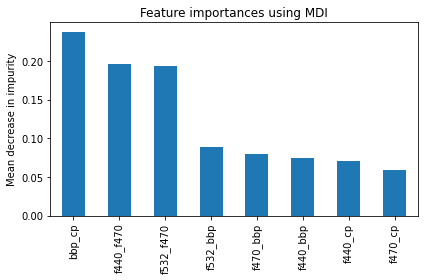

In [8]:
import matplotlib.pyplot as plt
model = SelectFromModel(gradient_boosting, prefit=True)
importances = gradient_boosting.feature_importances_

feature_names = ["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending = False).plot.bar(ax = ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig("C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Plots\impurity2.png", dpi = 300, bbox_inches='tight')

In [9]:
pd.Series(importances, index=feature_names)

f440_f470    0.195584
f532_f470    0.193940
bbp_cp       0.238061
f440_bbp     0.074949
f470_bbp     0.079870
f532_bbp     0.088566
f440_cp      0.070594
f470_cp      0.058436
dtype: float64

In [12]:
test = forest_importances[forest_importances > 0.05]

print("here is the significant parameters :", test.index)

new_descriptors = data[["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]]
no_cp = data[["f440_f470", "f532_f470", "f440_bbp", "f470_bbp", "f532_bbp"]]
no_532 = data[["f440_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f440_cp", "f470_cp"]]
no_cp_no_532 = data[["f440_f470", "f440_bbp", "f470_bbp"]]
no_bbp_no_cp_no_532 = data[["f440_f470"]]
no_440 = data[["f532_f470", "bbp_cp", "f470_bbp", "f532_bbp", "f470_cp"]]
only_mf = data[["f440_f470", "f532_f470"]]


ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(new_descriptors, target)
X_resampled, y_resampled = SMOTE().fit_resample(new_descriptors, target)
X_no_cp, y_resampled = SMOTE().fit_resample(no_cp, target)
X_no_532, y_resampled = SMOTE().fit_resample(no_532, target)
X_no_cp_no_532, y_resampled = SMOTE().fit_resample(no_cp_no_532, target)
X_no_bbp_no_cp_no_532, y_resampled = SMOTE().fit_resample(no_bbp_no_cp_no_532, target)
X_oligo, y_resampled = SMOTE().fit_resample(no_440, target)
X_only_mf, y_resampled = SMOTE().fit_resample(only_mf, target)

print(sorted(Counter(y_resampled).items()))

here is the significant parameters : Index(['f440_f470', 'f532_f470', 'bbp_cp', 'f440_bbp', 'f470_bbp', 'f532_bbp',
       'f440_cp', 'f470_cp'],
      dtype='object')
[(0, 32), (1, 32), (2, 32), (3, 32)]


In [13]:
X_resampled.describe()

,f440_f470,f532_f470,bbp_cp,f440_bbp,f470_bbp,f532_bbp,f440_cp,f470_cp
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.978058,1.094962,7365.505008,0.047638,0.061615,0.006148,339.352688,437.290728
std,1.001348,1.202865,2762.437579,0.030698,0.043080,0.003355,240.302501,322.723424
min,0.557068,0.368262,3679.000047,0.004211,0.002070,0.001216,31.299746,15.391041
25%,0.722460,0.647720,6143.561769,0.024275,0.032462,0.003773,183.600054,235.415092
50%,0.779848,0.727411,7014.590046,0.039315,0.048420,0.005084,297.021041,372.694525
75%,0.824266,1.003792,7788.399631,0.058437,0.082086,0.008197,427.431388,553.699063
max,8.232984,8.675062,22381.817012,0.155853,0.224920,0.017679,1705.947121,2178.754104


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_cp, X_test_no_cp, y_train, y_test = train_test_split(X_no_cp, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_532, X_test_no_532, y_train, y_test = train_test_split(X_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_cp_no_532, X_test_no_cp_no_532, y_train, y_test = train_test_split(X_no_cp_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_bbp_no_cp_no_532, X_test_no_bbp_no_cp_no_532, y_train, y_test = train_test_split(X_no_bbp_no_cp_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_only_mf, X_test_only_mf, y_train, y_test = train_test_split(X_only_mf, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_oligo, X_test_oligo, y_train, y_test = train_test_split(X_oligo, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)


In [15]:
#histogram boosting gradient classifer

new_hgb.fit(X_train,y_train)
y_pred_hgb = new_hgb.predict(X_test)

new_hgb.fit(X_train_no_cp,y_train)
y_pred_no_cp = new_hgb.predict(X_test_no_cp)

new_hgb.fit(X_train_no_532,y_train)
y_pred_no_532 = new_hgb.predict(X_test_no_532)

new_hgb.fit(X_train_no_cp_no_532,y_train)
y_pred_no_cp_no_532 = new_hgb.predict(X_test_no_cp_no_532)

new_hgb.fit(X_train_no_bbp_no_cp_no_532,y_train)
y_pred_no_bbp_no_cp_no_532 = new_hgb.predict(X_test_no_bbp_no_cp_no_532)

new_hgb.fit(X_train_only_mf, y_train)
y_pred_only_mf = new_hgb.predict(X_test_only_mf)

new_hgb.fit(X_train_oligo, y_train)
y_pred_oligo = new_hgb.predict(X_test_oligo)



Text(0.5, 1.0, 'Confusion Matrix of the Cross Validation using HGB')

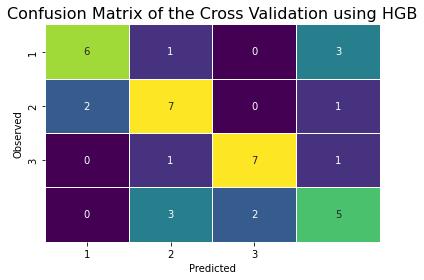

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_hgb)

#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cm_hgb, linewidths = 0.5, cmap = "viridis", annot = cm_hgb, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['1','2','3'])
ax.set_yticklabels(['1', '2', '3'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using HGB', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",precision_score(y_test, y_pred_hgb, average = None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",recall_score(y_test, y_pred_hgb, average = None))

Precision: [0.75       0.58333333 0.77777778 0.5       ]
Recall: [0.6        0.7        0.77777778 0.5       ]


Text(0.5, 1.0, 'Confusion Matrix of the Cross Validation using HGB')

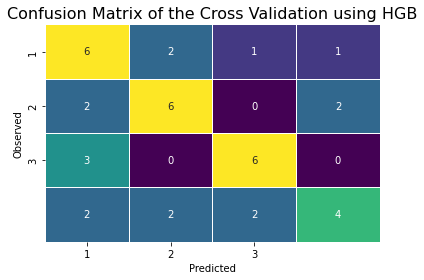

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_no_cp)

#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cm_hgb, linewidths = 0.5, cmap = "viridis", annot = cm_hgb, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['1','2','3'])
ax.set_yticklabels(['1', '2', '3'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using HGB', fontdict={'fontsize': 16, 'fontweight': 'medium'})

Text(0.5, 1.0, 'Confusion Matrix of the Cross Validation using HGB')

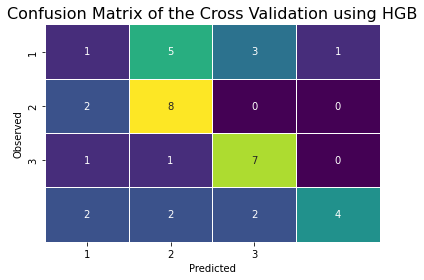

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_no_cp_no_532)

#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cm_hgb, linewidths = 0.5, cmap = "viridis", annot = cm_hgb, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['1','2','3'])
ax.set_yticklabels(['1', '2', '3'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using HGB', fontdict={'fontsize': 16, 'fontweight': 'medium'})

Text(0.5, 1.0, 'Confusion Matrix of the Cross Validation using HGB')

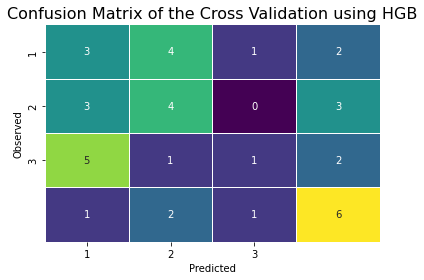

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_no_bbp_no_cp_no_532)

#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cm_hgb, linewidths = 0.5, cmap = "viridis", annot = cm_hgb, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['1','2','3'])
ax.set_yticklabels(['1', '2', '3'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using HGB', fontdict={'fontsize': 16, 'fontweight': 'medium'})

Text(0.5, 1.0, 'Confusion Matrix of the Cross Validation using HGB')

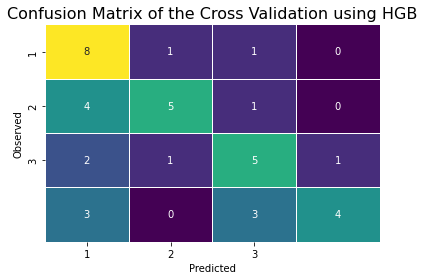

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_only_mf)

#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(cm_hgb, linewidths = 0.5, cmap = "viridis", annot = cm_hgb, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['1','2','3'])
ax.set_yticklabels(['1', '2', '3'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using HGB', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=20, random_state=0)
n_scores = cross_val_score(new_hgb, X_resampled, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
rec_scores = cross_val_score(new_hgb, X_resampled.values, y_resampled.values, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp = cross_val_score(new_hgb, X_no_cp, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp = cross_val_score(new_hgb, X_no_cp, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_532 = cross_val_score(new_hgb, X_no_532, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_532 = cross_val_score(new_hgb, X_no_532, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp_no_532 = cross_val_score(new_hgb, X_no_cp_no_532, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp_no_532 = cross_val_score(new_hgb, X_no_cp_no_532, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp_no_bbp_no_532 = cross_val_score(new_hgb, X_no_bbp_no_cp_no_532 , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp_no_bbp_no_532 = cross_val_score(new_hgb, X_no_bbp_no_cp_no_532 , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_only_mf = cross_val_score(new_hgb, X_only_mf , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_only_mf = cross_val_score(new_hgb, X_only_mf , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_oligo = cross_val_score(new_hgb, X_oligo , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_oligo = cross_val_score(new_hgb, X_oligo , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)




print('Accuracy with all sensors: %.3f (%.3f)' % (n_scores.mean()*100, n_scores.std()*100))
print('Recall with all sensors: %.3f (%.3f)' % (rec_scores.mean()*100, rec_scores.std()*100))

print('Accuracy without cp: %.3f (%.3f)' % (scores_no_cp.mean()*100, scores_no_cp.std()*100))
print('Recall without cp: %.3f (%.3f)' % (recall_no_cp.mean()*100, recall_no_cp.std()*100))

print('Accuracy without 532: %.3f (%.3f)' % (scores_no_532.mean()*100, scores_no_532.std()*100))
print('Recall without 532: %.3f (%.3f)' % (recall_no_532.mean()*100, recall_no_532.std()*100))

print('Accuracy without cp and F532: %.3f (%.3f)' % (scores_no_cp_no_532.mean()*100, scores_no_cp_no_532.std()*100))
print('Recall without cp and F532: %.3f (%.3f)' % (recall_no_cp_no_532.mean()*100, recall_no_cp_no_532.std()*100))

print('Accuracy without cp, bbp and F532: %.3f (%.3f)' % (scores_no_cp_no_bbp_no_532.mean()*100, scores_no_cp_no_bbp_no_532.std()*100))
print('Recall without cp, bbp and F532: %.3f (%.3f)' % (recall_no_cp_no_bbp_no_532.mean()*100, recall_no_cp_no_bbp_no_532.std()*100))

print('Accuracy with only mf: %.3f (%.3f)' % (scores_only_mf.mean()*100, scores_only_mf.std()*100))
print('Recall with only mf: %.3f (%.3f)' % (recall_only_mf.mean()*100, recall_only_mf.std()*100))

print('Accuracy without 440: %.3f (%.3f)' % (scores_oligo.mean()*100, scores_only_mf.std()*100))
print('Recall without 440: %.3f (%.3f)' % (recall_oligo.mean()*100, recall_only_mf.std()*100))


Accuracy with all sensors: 75.417 (12.247)
Recall with all sensors: 76.538 (10.735)
Accuracy without cp: 66.979 (12.259)
Recall without cp: 66.923 (12.427)
Accuracy without 532: 70.938 (16.516)
Recall without 532: 71.154 (17.350)
Accuracy without cp and F532: 58.750 (11.055)
Recall without cp and F532: 57.692 (12.522)
Accuracy without cp, bbp and F532: 41.458 (9.658)
Recall without cp, bbp and F532: 40.385 (9.692)
Accuracy with only mf: 63.854 (8.992)
Recall with only mf: 63.462 (9.061)
Accuracy without 440: 61.875 (8.992)
Recall without 440: 62.692 (9.061)


In [23]:
from functools import reduce

def unique(list1):
    x = np.array(list1)
    return(np.unique(x))
    
def plot_recall_score(X_list, y, X_names, cv = 10, return_scores = False, savepath = ""):
    """ 
            X: numpy_array/pandas dataframe n_rows, m_features
            y: numpy_array/pandas dataframe n_rows
            Plots min, max and avg kfold crosval_score for a list of models
        
    """
    
        
    
    names, mean_score = list(), list()
    std_score = list()
    ldf, ldf_std = list(), list()
    #mnames = list()
    
    for i, cluster in enumerate(unique(y)):

        rec_clust_desc, rec_clust_desc_error = list(), list()

        name = i
     
        for descriptors in X_list:
            
            rec_clust = list()

            for train_index, test_index in cv.split(descriptors, y):
                X_train, X_test = descriptors.iloc[train_index], descriptors.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf = new_hgb.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                rec = recall_score(y_test, y_pred, average=None)[i]
                
                rec_clust.append(rec)

            rec_clust_desc_mean = np.array(rec_clust).mean()
            rec_clust_desc_std = np.array(rec_clust).std()
            
            rec_clust_desc.append(rec_clust_desc_mean)
            rec_clust_desc_error.append(rec_clust_desc_std)
            
    
        tmp = pd.DataFrame({name: rec_clust_desc}, index = X_names)
        tmp_std = pd.DataFrame({name: rec_clust_desc_error}, index = X_names)
            
            
        ldf.append(tmp)
        ldf_std.append(tmp_std)
        
        
        mean_score = list()
    
    X = X_list[1]
        
    frame_scores = reduce(lambda X,y: pd.merge(X,y, left_index = True, right_index = True), ldf).T
    frame_std = reduce(lambda X,y: pd.merge(X,y, left_index = True, right_index = True), ldf_std).T
        
    
    
    fig, ax  = plt.subplots(1,1, figsize = (10,5))

    frame_scores.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black", yerr= frame_std)
    ax.legend(loc = 'best')
    ax.set_xlabel("")
    ax.set_title("Recall score by cluster for different sensors packages")
    ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation= 90 ) 
    
    fig.savefig(savepath, dpi = 300, bbox_inches='tight')

    if return_scores:    
        return frame_scores

In [24]:
from functools import reduce

def unique(list1):
    x = np.array(list1)
    return(np.unique(x))
    
def plot_precision_score(X_list, y, X_names, cv = 10, return_scores = False, savepath = ""):
    """ 
            X: numpy_array/pandas dataframe n_rows, m_features
            y: numpy_array/pandas dataframe n_rows
            Plots min, max and avg kfold crosval_score for a list of models
        
    """
    
        
    
    names, mean_score = list(), list()
    std_score = list()
    ldf, ldf_std = list(), list()
    #mnames = list()
    
    for i, cluster in enumerate(unique(y)):

        prec_clust_desc, prec_clust_desc_error = list(), list()

        name = i
     
        for descriptors in X_list:
            
            prec_clust = list()

            for train_index, test_index in cv.split(descriptors, y):
                X_train, X_test = descriptors.iloc[train_index], descriptors.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf = new_hgb.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                prec = precision_score(y_test, y_pred, average=None)[i]
                
                prec_clust.append(prec)

            prec_clust_desc_mean = np.array(prec_clust).mean()
            prec_clust_desc_std = np.array(prec_clust).std()
            
            prec_clust_desc.append(prec_clust_desc_mean)
            prec_clust_desc_error.append(prec_clust_desc_std)
            
    
        tmp = pd.DataFrame({name: prec_clust_desc}, index = X_names)
        tmp_std = pd.DataFrame({name: prec_clust_desc_error}, index = X_names)
            
            
        ldf.append(tmp)
        ldf_std.append(tmp_std)
        
        
        mean_score = list()
    
    X = X_list[1]
        
    frame_scores = reduce(lambda X,y: pd.merge(X,y, left_index = True, right_index = True), ldf).T
    frame_std = reduce(lambda X,y: pd.merge(X,y, left_index = True, right_index = True), ldf_std).T
        
    
    
    fig, ax  = plt.subplots(1,1, figsize = (10,5))

    frame_scores.plot.bar(ax = ax, cmap = 'RdYlBu', edgecolor = "black", yerr= frame_std)
    ax.legend(loc = 'best')
    ax.set_xlabel("")
    ax.set_title("Precision score by cluster for different sensors packages")
    ax.set_xticklabels(["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"])
    fig.savefig(savepath, dpi = 300, bbox_inches='tight')

    if return_scores:    
        return frame_scores

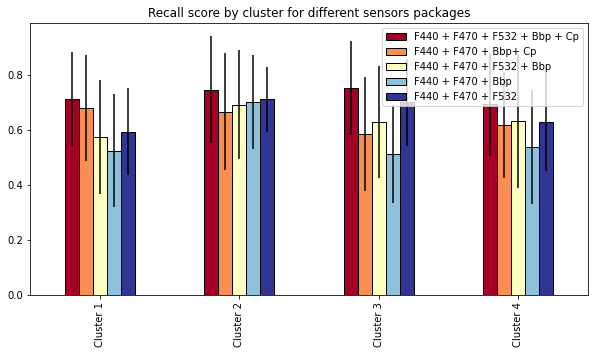

In [26]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

y = y_resampled

X_configs =[X_resampled,
         X_no_532,
         X_no_cp,
         X_no_cp_no_532,
         X_only_mf]

X_def = ["F440 + F470 + F532 + Bbp + Cp", "F440 + F470 + Bbp+ Cp", "F440 + F470 + F532 + Bbp", "F440 + F470 + Bbp", "F440 + F470 + F532"]

recall_plot = plot_recall_score(X_list = X_configs, y = y_resampled, X_names = X_def, cv = StratifiedShuffleSplit(n_splits=20, random_state=0, test_size = 0.2), return_scores=True, savepath = "C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Plots\\recall_test.png")

c:\Users\petit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\petit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\petit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

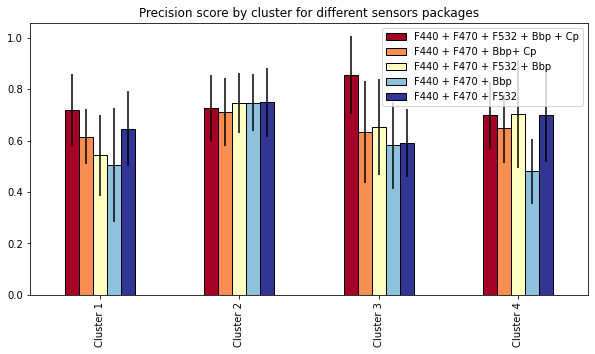

In [27]:
from sklearn.metrics import precision_score
t = plot_precision_score(X_list = X_configs, y = y_resampled, X_names = X_def, cv = StratifiedShuffleSplit(n_splits=20, random_state = 0, test_size = 0.2), return_scores=True, savepath = "C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Plots\\precision2.png")

In [39]:
data = pd.read_csv("C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Data\Compiled\hplc_mf_2_clusterised_cp.csv")

data = data.assign(f440_bbp = lambda x: x['fluo_440']/x['bb700'],
                f470_bbp= lambda x: x['fluo_470']/x['bb700'],
                f532_bbp = lambda x: x['fluo_532']/x['bb700'],
                f532_cp = lambda x: x['fluo_532']/x['cp'],
                f440_cp = lambda x: x['fluo_440']/x['cp'],
                f470_cp = lambda x: x['fluo_470']/x['cp'],
                f440b_f470b = lambda x: x['f440_bbp']/x['f470_bbp'],
                f532b_f470b = lambda x: x['f532_bbp']/x['f470_bbp'],
                f532_f440 = lambda x: x['fluo_532']/x['fluo_440'],
                bbp_cp = lambda x: x['bb700']/x['cp'])

full_descriptors = data[["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]]
target = data["cluster"]

ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(new_descriptors, target)
X_full, y_full = SMOTE().fit_resample(full_descriptors, target)

In [40]:
new_descriptors = data[["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]]
no_cp = data[["f440_f470", "f532_f470", "f440_bbp", "f470_bbp", "f532_bbp"]]
no_532 = data[["f440_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f440_cp", "f470_cp"]]
no_cp_no_532 = data[["f440_f470", "f440_bbp", "f470_bbp"]]
no_bbp_no_cp_no_532 = data[["f440_f470"]]
no_440 = data[["f532_f470", "bbp_cp", "f470_bbp", "f532_bbp", "f470_cp"]]
only_mf = data[["f440_f470", "f532_f470"]]


ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(new_descriptors, target)
X_resampled, y_resampled = SMOTE().fit_resample(new_descriptors, target)
X_no_cp, y_resampled = SMOTE().fit_resample(no_cp, target)
X_no_532, y_resampled = SMOTE().fit_resample(no_532, target)
X_no_cp_no_532, y_resampled = SMOTE().fit_resample(no_cp_no_532, target)
X_no_bbp_no_cp_no_532, y_resampled = SMOTE().fit_resample(no_bbp_no_cp_no_532, target)
X_oligo, y_resampled = SMOTE().fit_resample(no_440, target)
X_only_mf, y_resampled = SMOTE().fit_resample(only_mf, target)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_cp, X_test_no_cp, y_train, y_test = train_test_split(X_no_cp, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_532, X_test_no_532, y_train, y_test = train_test_split(X_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_cp_no_532, X_test_no_cp_no_532, y_train, y_test = train_test_split(X_no_cp_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_no_bbp_no_cp_no_532, X_test_no_bbp_no_cp_no_532, y_train, y_test = train_test_split(X_no_bbp_no_cp_no_532, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_only_mf, X_test_only_mf, y_train, y_test = train_test_split(X_only_mf, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)
X_train_oligo, X_test_oligo, y_train, y_test = train_test_split(X_oligo, y_resampled, test_size =0.3, stratify = y_resampled, random_state=0)


In [42]:
#histogram boosting gradient classifer

new_hgb.fit(X_train,y_train)
y_pred_hgb = new_hgb.predict(X_test)

new_hgb.fit(X_train_no_cp,y_train)
y_pred_no_cp = new_hgb.predict(X_test_no_cp)

new_hgb.fit(X_train_no_532,y_train)
y_pred_no_532 = new_hgb.predict(X_test_no_532)

new_hgb.fit(X_train_no_cp_no_532,y_train)
y_pred_no_cp_no_532 = new_hgb.predict(X_test_no_cp_no_532)

new_hgb.fit(X_train_no_bbp_no_cp_no_532,y_train)
y_pred_no_bbp_no_cp_no_532 = new_hgb.predict(X_test_no_bbp_no_cp_no_532)

new_hgb.fit(X_train_only_mf, y_train)
y_pred_only_mf = new_hgb.predict(X_test_only_mf)

new_hgb.fit(X_train_oligo, y_train)
y_pred_oligo = new_hgb.predict(X_test_oligo)


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=20, random_state=0)
n_scores = cross_val_score(new_hgb, X_resampled, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
rec_scores = cross_val_score(new_hgb, X_resampled.values, y_resampled.values, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp = cross_val_score(new_hgb, X_no_cp, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp = cross_val_score(new_hgb, X_no_cp, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_532 = cross_val_score(new_hgb, X_no_532, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_532 = cross_val_score(new_hgb, X_no_532, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp_no_532 = cross_val_score(new_hgb, X_no_cp_no_532, y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp_no_532 = cross_val_score(new_hgb, X_no_cp_no_532, y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_no_cp_no_bbp_no_532 = cross_val_score(new_hgb, X_no_bbp_no_cp_no_532 , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_no_cp_no_bbp_no_532 = cross_val_score(new_hgb, X_no_bbp_no_cp_no_532 , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_only_mf = cross_val_score(new_hgb, X_only_mf , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_only_mf = cross_val_score(new_hgb, X_only_mf , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)
scores_oligo = cross_val_score(new_hgb, X_oligo , y_resampled, scoring = "balanced_accuracy", cv = cv, n_jobs = 2)
recall_oligo = cross_val_score(new_hgb, X_oligo , y_resampled, scoring = "recall_weighted", cv = cv, n_jobs = 2)




print('Accuracy with all sensors: %.3f (%.3f)' % (n_scores.mean()*100, n_scores.std()*100))
print('Recall with all sensors: %.3f (%.3f)' % (rec_scores.mean()*100, rec_scores.std()*100))

print('Accuracy without cp: %.3f (%.3f)' % (scores_no_cp.mean()*100, scores_no_cp.std()*100))
print('Recall without cp: %.3f (%.3f)' % (recall_no_cp.mean()*100, recall_no_cp.std()*100))

print('Accuracy without 532: %.3f (%.3f)' % (scores_no_532.mean()*100, scores_no_532.std()*100))
print('Recall without 532: %.3f (%.3f)' % (recall_no_532.mean()*100, recall_no_532.std()*100))

print('Accuracy without cp and F532: %.3f (%.3f)' % (scores_no_cp_no_532.mean()*100, scores_no_cp_no_532.std()*100))
print('Recall without cp and F532: %.3f (%.3f)' % (recall_no_cp_no_532.mean()*100, recall_no_cp_no_532.std()*100))

print('Accuracy without cp, bbp and F532: %.3f (%.3f)' % (scores_no_cp_no_bbp_no_532.mean()*100, scores_no_cp_no_bbp_no_532.std()*100))
print('Recall without cp, bbp and F532: %.3f (%.3f)' % (recall_no_cp_no_bbp_no_532.mean()*100, recall_no_cp_no_bbp_no_532.std()*100))

print('Accuracy with only mf: %.3f (%.3f)' % (scores_only_mf.mean()*100, scores_only_mf.std()*100))
print('Recall with only mf: %.3f (%.3f)' % (recall_only_mf.mean()*100, recall_only_mf.std()*100))

print('Accuracy without 440: %.3f (%.3f)' % (scores_oligo.mean()*100, scores_only_mf.std()*100))
print('Recall without 440: %.3f (%.3f)' % (recall_oligo.mean()*100, recall_only_mf.std()*100))


Accuracy with all sensors: 83.500 (10.618)
Recall with all sensors: 84.000 (9.165)
Accuracy without cp: 78.000 (10.296)
Recall without cp: 76.000 (10.198)
Accuracy without 532: 80.500 (12.440)
Recall without 532: 79.500 (12.440)
Accuracy without cp and F532: 78.000 (10.296)
Recall without cp and F532: 78.000 (10.296)
Accuracy without cp, bbp and F532: 71.000 (10.909)
Recall without cp, bbp and F532: 71.000 (10.909)
Accuracy with only mf: 68.000 (16.912)
Recall with only mf: 69.500 (17.168)
Accuracy without 440: 80.500 (16.912)
Recall without 440: 81.000 (17.168)


In [ ]:

precision_plot = plot_precision_score(X_list = X_configs, y = y_resampled, X_names = X_def, cv = StratifiedShuffleSplit(n_splits=20, random_state=0, test_size = 0.2), return_scores=True, savepath = "C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Plots\\precision_3_cluster.png")

In [ ]:
#test to predict on the ctd data

ctd_data = pd.read_csv("C:\\Users\petit\Documents\These\Multispectral-Fluorescence\Boussole\Output\Data\Compiled\\test_continuous_data.csv")

#select the raw descriptors
descriptors_raw_name = ["fluo_440", "fluo_470", "fluo_532", "bb700", "cp"]

#select the profile
prof_selected = 233
ctd_prof = ctd_data[ctd_data.bouss == prof_selected]
ctd_prof = ctd_prof[ctd_prof.depth < 81]
ctd_prof=ctd_prof.dropna().reset_index(drop=True)

#get descriptors
descriptors_raw = ctd_prof[descriptors_raw_name]

descriptors_raw.head()

In [ ]:
descriptors = descriptors_raw.assign(f440_bbp = lambda x: x['fluo_440']/x['bb700'],
                f470_bbp= lambda x: x['fluo_470']/x['bb700'],
                f532_bbp = lambda x: x['fluo_532']/x['bb700'],
                f440_f470 = lambda x: x['fluo_440']/x['fluo_470'],
                f532_f470 = lambda x: x['fluo_532']/x['fluo_470'],
                f532_cp = lambda x: x['fluo_532']/x['cp'],
                f440_cp = lambda x: x['fluo_440']/x['cp'],
                f470_cp = lambda x: x['fluo_470']/x['cp'],
                f440b_f470b = lambda x: x['f440_bbp']/x['f470_bbp'],
                f532b_f470b = lambda x: x['f532_bbp']/x['f470_bbp'],
                f532_f440 = lambda x: x['fluo_532']/x['fluo_440'],
                bbp_cp = lambda x: x['bb700']/x['cp'])

descriptors = descriptors[["f440_f470", "f532_f470", "bbp_cp", "f440_bbp", "f470_bbp", "f532_bbp", "f440_cp", "f470_cp"]]

descriptors.head()

In [ ]:
new_hgb.fit(X_full,y_full)
cluster_predicted = new_hgb.predict(descriptors)

In [ ]:
ctd_prof_clust = ctd_prof.assign(pop = cluster_predicted)

In [ ]:
import seaborn as sb
ctd_prof_clust['depth'] = -ctd_prof_clust['depth']

fg = sb.FacetGrid(data=ctd_prof_clust, hue='pop', aspect=1.61, palette=["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"])
fg.map(plt.scatter, 'fluo_470', 'depth').add_legend()